# Spot-checking inicial: Naive Bayes

## Carregamento dos Dados e Preparação do Ambiente

### Instalação de Pacotes

In [ ]:
! pip install pandas numpy matplotlib scikit-learn imbalanced-learn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gaussian: filename=gaussian-0.1-py3-none-any.whl size=4718 sha256=03b98148e9d58b4f8a756d2b66860e07755dfb8ea330bb5c425870595c74dacb
  Stored in directory: /home/max/.cache/pip/wheels/9f/1b/26/ff52be80e50b55c2dd394504050c7a202923864883aba88ec7
Successfully built gaussian


### Importação de Bibliotecas
Na célula seguinte são importadas bibliotecas e métodos que serão utilizadas repetidamente ao longo da análise.

In [10]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, f1_score,
    ConfusionMatrixDisplay
)

from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from utils.visualization import plot_metrics_by_class, print_summary_metrics, print_summary_metrics_latex

### Definição de Constantes Auxiliares
Na célula seguinte são definidas constantes utilitárias diversas que serão usadas ao longo da análise.

In [11]:
random_state = 42

test_ratio = 0.15

train_ratio_holdout = 0.70
valid_ratio_holdout = 0.15

numeric_attrs = ["idade_paciente", "dias_sintomas_notificacao"]

### Obtenção e análise dos dados
O código abaixo carrega o dataset utilizando as funções do scikit-learn e mostra algumas informações básicas sobre os dados

In [5]:
df_sinan_processed = pd.read_csv("../data/3_gold/dataset-processed.csv")

X = df_sinan_processed.drop("severity", axis=1)
y = df_sinan_processed["severity"]

feature_names = X.columns.tolist()
target_names = ["low_risk", "alarm", "severe"]

y = y.map({name: idx for idx, name in enumerate(target_names)})

### Separação do Conjunto de Teste
Essa separação é realizada independentemente do algoritmo utilizado para particionar os dados entre treino e validação (holdout ou LOOCV).

In [12]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_state, stratify=y)

### Particionamento dos Dados (Holdout)

In [13]:
# Fazendo a segunda divisão, para gerar o conjunto de treino e validação
final_test_size = valid_ratio_holdout / (train_ratio_holdout + test_ratio)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=final_test_size, random_state=random_state, stratify=y_temp)

# Normalizando atributos numéricos
for col in numeric_attrs:
    mean = X_train[col].mean()
    std = X_train[col].std()
    X_train[col] = (X_train[col] - mean) / (std + 1e-8)
    X_valid[col] = (X_valid[col] - mean) / (std + 1e-8)
    X_test[col] = (X_test[col] - mean) / (std + 1e-8)

print(f"Conjuntos gerados com as seguintes proporções: ")
print(f"  Treinamento: {X_train.shape}")
print(f"  Validação: {X_valid.shape}")
print(f"  Teste: {X_test.shape}")

Conjuntos gerados com as seguintes proporções: 
  Treinamento: (501841, 42)
  Validação: (107538, 42)
  Teste: (107538, 42)


## Amostragem de Dados

### Amostragem com SMOTE

In [14]:
class_counts = Counter(y_train)

print(f"Distribuição original das classes no conjunto de treinamento: {class_counts}")

under_sampler = RandomUnderSampler(sampling_strategy={0: class_counts[1]}, random_state=random_state)
over_sampler = SMOTE(sampling_strategy={2: class_counts[1]}, random_state=random_state)

pipeline = Pipeline([
    ('under', under_sampler),
    ('over', over_sampler)
])

X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print(f"Distribuição das classes após amostragem no conjunto de treinamento: {Counter(y_train_resampled)}")

Distribuição original das classes no conjunto de treinamento: Counter({0: 294594, 1: 187280, 2: 19967})
Distribuição das classes após amostragem no conjunto de treinamento: Counter({0: 187280, 1: 187280, 2: 187280})


In [17]:
nb = GaussianNB()
nb.fit(X_train_resampled, y_train_resampled)

y_pred = nb.predict(X_valid)
f1_valid = f1_score(y_valid, y_pred, average='macro', zero_division=0)

y_pred_train = nb.predict(X_train)
f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=0)


print(f"\nF1 validação: {f1_valid:.3f}")


F1 validação: 0.281


Para avaliarmos o desempenho do modelo otimizado em novos dados, devemos repetir o treinamento selecionando o melhor valor de hiperparâmetro(s) com base no gráfico anterior, e fazer a avaliação nos dados de teste.
Para melhorar a capacidade de estimar o desempenho do modelo, podemos treinar com os dados de treinamento e validação, tendo em vista que ambos são independentes do conjunto de teste (dados nunca vistos).


In [18]:
X_train_full = np.concatenate((X_train, X_valid), axis=0)
y_train_full = np.concatenate((y_train, y_valid), axis=0)

class_counts = Counter(y_train_full)

under_sampler = RandomUnderSampler(sampling_strategy={0: class_counts[1]}, random_state=random_state)
over_sampler = SMOTE(sampling_strategy={2: class_counts[1]}, random_state=random_state)

pipeline = Pipeline([
    ('under', under_sampler),
    ('over', over_sampler)
])

X_train_final, y_train_final = pipeline.fit_resample(X_train_full, y_train_full)

nb = GaussianNB()
nb.fit(X_train_final, y_train_final)

y_pred = nb.predict(X_test)

f1_test = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"F1-Macro (Dados de Teste): {f1_test:.3f}")

F1-Macro (Dados de Teste): 0.365


/home/max/ML/TrabalhoPraticoML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


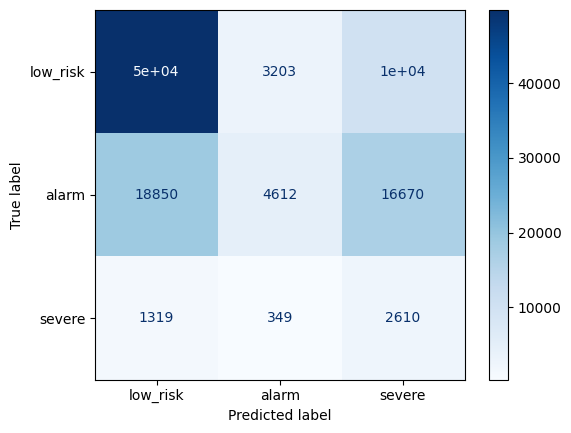

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names, cmap=plt.cm.Blues)

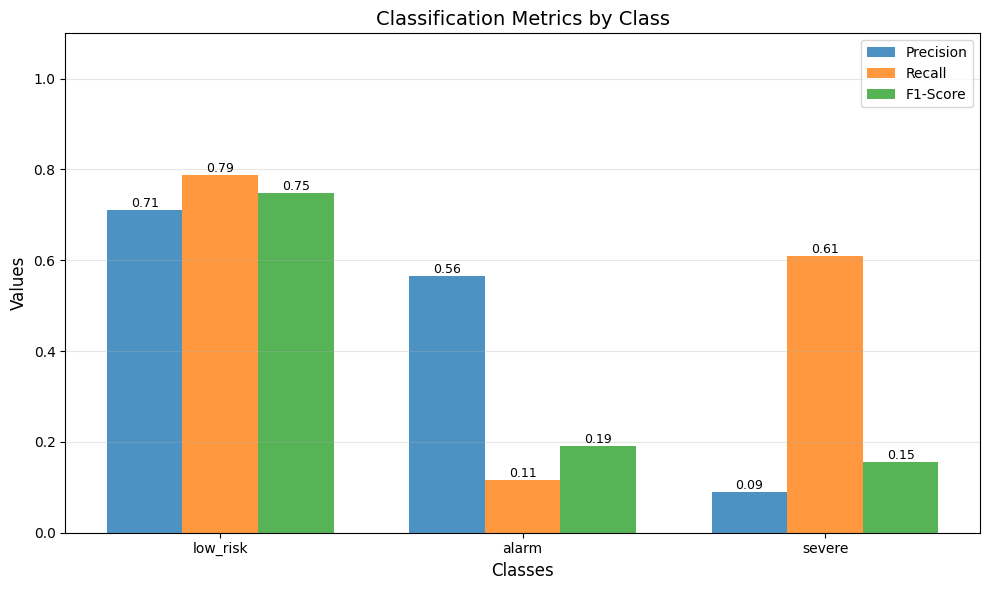

In [20]:
fig, ax, report_dict = plot_metrics_by_class(y_test, y_pred, target_names=target_names)

In [21]:
print_summary_metrics(report_dict)


              CLASSIFICATION METRICS (SUMMARY)              

Accuracy: 0.530

                        Precision       Recall     F1-Score
------------------------------------------------------------
Macro Avg                   0.455        0.505        0.365
Weighted Avg                0.632        0.530        0.517



In [22]:
print_summary_metrics_latex(report_dict)


\begin{table}
\caption{Classification Metrics (Accuracy: 0.530)}
\label{tab:metrics}
\begin{tabular}{lrr}
\toprule
Metric & Macro Avg & Weighted Avg \\
\midrule
Precision & 0.455 & 0.632 \\
Recall & 0.505 & 0.530 \\
F1-Score & 0.365 & 0.517 \\
\bottomrule
\end{tabular}
\end{table}

